# Find h-bonds

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import os
import csv
import time
import ast
plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')

### Functions

$ \alpha = arccos( \frac{ ( V_1 \times V_2 ) \hspace{.1cm} \cdot \hspace{.1cm} ( V_2 \times V_3 ) }{\lvert V_1 \times V_2 \rvert \hspace{.1cm} \cdot \hspace{.1cm} \lvert V_2 \times V_3 \rvert} ) \hspace{.5cm}$
$V_n = (P_n \times P_{n+1})$

If the vectors u = (u1, u2, u3), v = (v1, v2, v3) and w = (w1, w2, w3) are vectors in 3-space with the
same initial point,

then they lie in the same plane if and only if

u(v x w) = 0

In [3]:
def get_file_length(input_file):
    with open(input_file) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def calc_dihedral(p1, p2, p3, p4):
    
    #get vectors from atom coordinates
    v1 = p2 - p1
    v2 = p3 - p2
    v3 = p4 - p3

    #cross vectors and normalize terms 
    c1 = np.cross(v1, v2)
    c1 = c1 / (c1 * c1).sum(-1)**0.5
    c2 = np.cross(v2, v3)
    c2 = c2 / (c2 * c2).sum(-1)**0.5
    
    #plug terms and get dihedral angle
    rad = np.arccos((c1*c2).sum(-1) / ((c1**2).sum(-1) * (c2**2).sum(-1))**0.5)
    
    #corrects sign if orthogonal vectors
    porm = np.sign((c1 * v3).sum(-1))
    if not porm == 0:
        rad = rad * porm

    return rad

### Read-in from .pdb

In [17]:
filename='5w7v_3layers_neg120p44_h.pdb'
datadir='/Users/NikosMynhier/Desktop/'
input_file = open(f'{datadir}{filename}','r')
file_length = get_file_length(f'{datadir}{filename}')

atom = []
atomno = []
nama = []
resn = []
chainid = []
resida = []
xa = []
ya = []
za = []
occup = []
q = []
elem = []
charge = []
for lines in range(file_length):
    line = input_file.readline()
    #line = str(line)
    if line[0:4] == 'ATOM':
        atom.append(line[0:6])
        atomno.append(line[6:11])
        nama.append(line[12:17])
        resn.append(line[17:20])
        chainid.append(line[21:22])
        resida.append(int(line[22:26]))
        xa.append(float(line[30:38]))
        ya.append(float(line[38:46]))
        za.append(float(line[46:54]))
        occup.append(line[54:60])
        q.append(line[60:66])
        elem.append(line[76:78])
        charge.append(line[78:80])
d = {'Atom': atom, 'Atom Number': atomno, 'Atom Name': nama, 'Residue Name': resn, 'Chain ID': chainid, 'Residue Number': resida, 'X': xa, 'Y': ya, 'Z': za, 'Occupancy': occup, 'Q_score': q, 'Element': elem, 'Charge': charge} 
df = pd.DataFrame(d)
input_file.close()

,Atom,Atom Number,Atom Name,Residue Name,Chain ID,Residue Number,X,Y,Z,Occupancy,Q_score,Element,Charge
0,ATOM,1,N,ASP,A,1,39.605,7.967,6.710,1.00,103.79,N,\n
1,ATOM,2,CA,ASP,A,1,38.587,8.767,6.040,1.00,103.79,C,\n
2,ATOM,3,C,ASP,A,1,37.700,9.505,7.034,1.00,103.79,C,\n
3,ATOM,4,O,ASP,A,1,37.942,9.464,8.232,1.00,103.79,O,\n
4,ATOM,5,CB,ASP,A,1,37.738,7.885,5.126,1.00,103.65,C,\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12982,ATOM,0,HE2,LYS,I,165,-55.018,-25.202,25.296,1.00,125.77,H,
12983,ATOM,0,HE3,LYS,I,165,-54.973,-24.333,24.001,1.00,125.77,H,
12984,ATOM,0,HZ1,LYS,I,165,-57.129,-24.827,24.535,1.00,125.77,H,
12985,ATOM,0,HZ2,LYS,I,165,-56.832,-25.447,23.255,1.00,125.77,H,


### Calculations

____
Dihedral angles
___

φ (phi) involves the backbone atoms C-N-Cα-C

ψ (psi) involves the backbone atoms N-Cα-C-N

In [46]:
#Get Psi angles
Res_num, ψ_angles = 0, []
index1 = []
N1 = np.array([ df['X'][0], df['Y'][0], df['Z'][0] ])
for i in range(len(df)):
    if df['Residue Number'][i] != Res_num:
        if 'N' in df['Atom Name'][i]:
            N2 = np.array([ df['X'][i], df['Y'][i], df['Z'][i] ])
            if set(N2).difference(set(N1)) != set():
            #if N2[0] != N1[0]:
                alpha = calc_dihedral(N1,Ca,C1,N2)
                ψ_angles.append([Ca_index, alpha*180/np.pi])
                index1.append(i)
            N1 = np.array([ df['X'][i], df['Y'][i], df['Z'][i] ])
            Ca = np.array([ df['X'][i+1], df['Y'][i+1], df['Z'][i+1] ])
            C1 = np.array([ df['X'][i+2], df['Y'][i+2], df['Z'][i+2] ])
            Ca_index = i + 1
        Res_num = df['Residue Number'][i]        

ψ_col = [None for i in range(len(df))]
for i in range(len(ψ_col)):
    for j in range(len(ψ_angles)):
        if i == ψ_angles[j][0]:
            ψ_col[i] = ψ_angles[j][1]
        
df['ψ Angle'] = ψ_col
index1_set = set(index1)

In [47]:
#Get Phi angles
Res_num, φ_angles= 0, []
index2 = []
C1 = np.array([ df['X'][2], df['Y'][2], df['Z'][2] ])
for i in range(len(df)):
    if df['Residue Number'][i] != Res_num:
        if 'N' in df['Atom Name'][i]:
            N1 = np.array([ df['X'][i], df['Y'][i], df['Z'][i] ])
            Ca = np.array([ df['X'][i+1], df['Y'][i+1], df['Z'][i+1] ])
            C2 = np.array([ df['X'][i+2], df['Y'][i+2], df['Z'][i+2] ])
            if set(C2).difference(set(C1)):
            #if C2[0] != C1[0]:
                Ca_index = i + 1
                alpha = calc_dihedral(C1,N1,Ca,C2)
                φ_angles.append([Ca_index, alpha*180/np.pi])
                index2.append(i)
            C1 = np.array([ df['X'][i+2], df['Y'][i+2], df['Z'][i+2] ])
        Res_num = df['Residue Number'][i]
        
φ_col = [None for i in range(len(df))]
for i in range(len(φ_col)):
    for j in range(len(φ_angles)):
        if i == φ_angles[j][0]:
            φ_col[i] = φ_angles[j][1]
df['φ Angle'] = φ_col
index2_set = set(index2)

In [48]:
print(len(index1), len(index2))
print(len(index1_set), len(index2_set))
index2_set.difference(index1_set)

791 791
791 791


set()

___
Ramachandran Plot
___

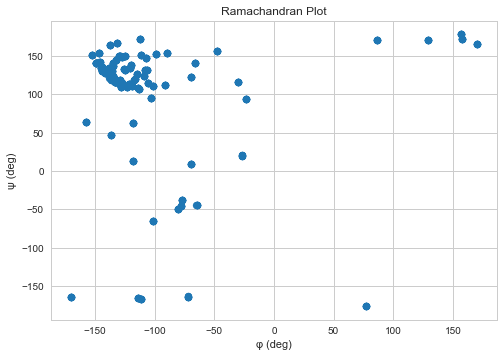

In [49]:
#Dihedral Angles add one to the begining and one to the end
φ = [None]
φ.extend(φ_angles[i][1] for i in range(len(φ_angles)))
ψ = [ψ_angles[i][1] for i in range(len(ψ_angles)) ]
ψ.append(None)

#Plot
plt.scatter(φ, ψ)
plt.title("Ramachandran Plot")
plt.xlabel("φ (deg)")
plt.ylabel("ψ (deg)")
plt.show()


In [ ]:
structure = []
for i in range(len(φ)):
    temp = []
    if φ[i] != None and ψ[i] != None:
        if -180 < φ[i] < -45 and 45 < ψ[i] < 225:
            temp.append('B-Strand')
        if -180 < φ[i] < -0 and -100 < ψ[i] < 45:
            temp.append('A-Helix')
        if -90 < φ[i] < 90 and 0 < ψ[i] < 180:
            temp.append('Turn')
        if φ[i] > 90 or ψ[i] < -100:
            temp.append('Misc')
    else:
        temp.append('Misc')   
    structure.append(temp)

if len(structure) != len(φ):
    print("something wrong")

In [ ]:
start = [ψ_angles[0][0]]
Ca_temp = [φ_angles[i][0] for i in range(len(φ_angles))]
Ca_col = start + Ca_temp
structure_col = [None for i in range(len(df))]
for i in range(len(structure_col)):
    for j in range(len(Ca_col)):
        if i == Ca_col[j]:
            structure_col[i] = str(structure[j])
df['structure'] = structure_col

##Calculate b-b h-bond distances

In [ ]:
#Get a list of the Chain IDs
temp = ['poop']
all_chain_IDs = [] 
num_chains = 0
num_atm_chn = 0
for i in df['Chain ID']:
    if temp != i:
        all_chain_IDs.append(i)
        temp = i
        num_chains += 1
        num_atm_chn = 0
    if temp == i:
        num_atm_chn += 1

In [ ]:
chainid

In [ ]:
#Calculate centers of mass for each chain
#chainid, xa, ya, za = np.array(df['Chain ID']), np.array(df['X']), np.array(df['Y']), np.array(df['Z'])
length = len(chainid)
print(length)
print(num_chains)
comx, comy, comz = [], [], []
for i in range(num_chains):
    sumx, sumy, sumz = 0, 0, 0
    for j in range(length):
        if chainid[j] == all_chain_IDs[i]:
            sumx += (xa[j])
            sumy += (ya[j])
            sumz += (za[j])
    comx.append(sumx/num_atm_chn)
    comy.append(sumy/num_atm_chn)
    comz.append(sumz/num_atm_chn)
print(comx,comy,comz)

### Define Functions

In [ ]:
def get_dist(x2,x1,y2,y1,z2,z1):
    return np.sqrt((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)

In [ ]:
#Calculate all backbone-backbone h-bonds 
dist = []
radius = []
chain_ID_H = []
chain_ID_O = []
residue_number_H = []
residue_number_O = []
residue_name_H = []
residue_name_O = []
atom_name_H = []
atom_name_O = []
#start = time.time()
for i in range(num_chains):
    for j in range(num_chains):
        diffcomx=comx[i]-comx[j]
        diffcomy=comy[i]-comy[j]
        diffcomz=comz[i]-comz[j]
        diffcom=np.sqrt(diffcomx**2+diffcomy**2+diffcomz**2)
        if diffcom>4 and diffcom<5.2:
            print(all_chain_IDs[i],all_chain_IDs[j])
            for k in range(length):
                if nama[k][1:5]=='H   ' and chainid[k]==all_chain_IDs[i]:
                        for l in range(length):
                            if nama[l][1:3]=='O ' and chainid[l]==all_chain_IDs[j] and resida[l]==resida[k]-1 and 1.6<get_dist(xa[k],xa[l],ya[k],ya[l],za[k],za[l])<2.6:
                                dist.append(get_dist(xa[k],xa[l],ya[k],ya[l],za[k],za[l]))
                                radius.append(np.sqrt(((xa[k]**2+((ya[k])**2)))))
                                chain_ID_H.append(chainid[k])
                                chain_ID_O.append(chainid[l])
                                residue_number_H.append(resida[k])
                                residue_number_O.append(resida[l])
                                residue_name_H.append(resn[k])
                                residue_name_O.append(resn[l])
                                atom_name_H.append(nama[k])
                                atom_name_O.append(nama[l])

dist

In [ ]:
print(len(atom_name_O))

In [ ]:
#Calculate the "tilt" of each residue by measuring backbone carbonyl bond vector magnitude on X, Y plane
CO_xy=[]
CO_tilt=[]
CO_radius=[]
CO_chainid=[]
CO_residue_number=[]
CO_residue_name=[]
for i in range(length):
    if nama[i]==' C   ':
        #print(nama[i])
        #print(nama[i+1])
        CO_xy.append(np.sqrt((xa[i+1]-xa[i])**2+(ya[i+1]-ya[i])**2))
        CO_tilt.append(90-(180/3.14)*np.arccos((np.sqrt((xa[i+1]-xa[i])**2+(ya[i+1]-ya[i])**2))/1.23))
        CO_radius.append(np.sqrt(xa[i]**2+ya[i]**2))
        CO_chainid.append(chainid[i])
        CO_residue_number.append(resida[i])
        CO_residue_name.append(resn[i])
        #print(CO_xy)
#    if nama[i]==' C  A':
#        #print(nama[i])
#        #print(nama[i+2])
#        CO_xy.append(np.sqrt((xa[i+2]-xa[i])**2+(ya[i+1]-ya[i])**2))
#        CO_tilt.append(90-(180/3.14)*np.arccos((np.sqrt((xa[i+1]-xa[i])**2+(ya[i+1]-ya[i])**2))/1.23))
#        CO_radius.append(np.sqrt(xa[i]**2+ya[i]**2))
#        CO_chainid.append(chainid[i])
#        CO_residue_number.append(resida[i])
#        CO_residue_name.append(resn[i])
#        #print(CO_xy)
#    if nama[i]==' C  B':
#        #print(nama[i])
#        #print(nama[i+2])
#        CO_xy.append(np.sqrt((xa[i+2]-xa[i])**2+(ya[i+2]-ya[i])**2))
#        CO_tilt.append(90-(180/3.14)*np.arccos((np.sqrt((xa[i+1]-xa[i])**2+(ya[i+1]-ya[i])**2))/1.23))
#        CO_radius.append(np.sqrt(xa[i]**2+ya[i]**2))
#        CO_chainid.append(chainid[i])
#        CO_residue_number.append(resida[i])
#        CO_residue_name.append(resn[i])
#        #print(CO_xy)
        
for i in range(len(CO_radius)):
    print(CO_xy[i],CO_tilt[i],CO_radius[i],CO_chainid[i],CO_residue_number[i],CO_residue_name[i])
    



In [ ]:
#Assign a tilt to each h-bond identified above
h_bond_tilt=[]
for i in range(len(dist)):
    #print(CO_residue_number[i])
    for j in range(len(CO_radius)):
        if CO_residue_number[j]==residue_number_O[i] and CO_residue_name[j]==residue_name_O[i] and CO_chainid[j]==chain_ID_O[i]:
            h_bond_tilt.append(CO_tilt[j])
            print(CO_residue_number[j],residue_number_O[i],CO_residue_name[j],residue_name_O[i],CO_radius[j],radius[i],CO_tilt[j],CO_chainid[j],chain_ID_O[i])
#print(len(residue_number_O))
print(len(h_bond_tilt))

In [ ]:
print(len(CO_radius))

In [ ]:
print(len(radius),len(dist),len(h_bond_tilt),len(atom_name_H),len(residue_name_H),len(chain_ID_H),len(residue_number_H),len(atom_name_O),len(residue_name_O),len(chain_ID_O),len(residue_number_O))
for i in range(len(dist)):
    print(radius[i],dist[i],h_bond_tilt[i],atom_name_H[i],residue_name_H[i],chain_ID_H[i],residue_number_H[i],atom_name_O[i], residue_name_O[i],chain_ID_O[i],residue_number_O[i])

In [ ]:
d = {'radius':radius,'dist': dist,'tilt': h_bond_tilt,'atom_name_H': atom_name_H,'residue_name_H': residue_name_H,'chain_ID_H': chain_ID_H,'residue_number_H': residue_number_H,'atom_name_O': atom_name_O, 'residue_name_O': residue_name_O,'chain_ID_O': chain_ID_O,'residue_number_O': residue_number_O}
h_bonds = pd.DataFrame(d)
h_bonds

# H and O structure relationships

In [ ]:
HnO_struc = []
for i in range(len(h_bonds)):
    break_bi = 0
    temp = []
    for j in range(len(df)):
        if h_bonds['residue_number_O'][i] == df['Residue Number'][j]:
            if 'CA' in df['Atom Name'][j]:
                temp.append(ast.literal_eval(df['structure'][j]))
        if h_bonds['residue_number_H'][i] == df['Residue Number'][j]:
            if 'CA' in df['Atom Name'][j]:
                temp.append(ast.literal_eval(df['structure'][j]))
                break_bi = 1
        if break_bi == 1:
            break
    HnO_struc.append(temp)  
h_bonds['H & O Strucs'] = HnO_struc

In [ ]:
h_bonds['H & O Strucs']

In [ ]:
h_bonds

# TO DO

In [ ]:
#df.to_csv("/Users/NikosMynhier/Desktop/David/Alpha_Psi_Calculation/fixed_pdbs_h/6n3c_origin_5layers_h_+ang_+struc.pdb",index=False)
h_bonds.to_csv(f'{filename}'[0:4] + str(".csv"), index=False)


In [ ]:
colors = []
colors_onlyBB = []
radius_onlyBB = []
dist_onlyBB = []
tilt_onlyBB = []
for i in range(len(h_bonds)):
    if h_bonds['H & O Strucs'][i] == [['B-Strand'], ['B-Strand']]:
        colors.append('red')
        colors_onlyBB.append('red')
        radius_onlyBB.append(h_bonds['radius'][i])
        dist_onlyBB.append(h_bonds['dist'][i])
        tilt_onlyBB.append(h_bonds['tilt'][i])
    else:
        colors.append('blue')

In [ ]:
plt.scatter(h_bonds['radius'], h_bonds['dist'], c=colors)
plt.legend(['Red = Beta-Beta, Blue = else'], frameon=False, loc='upper right')
plt.title(filename, fontsize=15)
plt.xlabel("Radius", fontsize=15)
plt.ylabel("Dist", fontsize=15)
plt.show()

In [ ]:
plt.scatter(h_bonds['radius'], h_bonds['tilt'], c=colors)
plt.legend(['Red = Beta-Beta, Blue = else'], frameon=False, loc='upper right')
plt.title(filename, fontsize=15)
plt.xlabel("Radius", fontsize=15)
plt.ylabel("Tilt", fontsize=15)
plt.show()

In [ ]:
[a, b, c] = np.polyfit(radius_onlyBB, tilt_onlyBB, 2)
x2d = np.linspace(0,50,100)
y2d = a*(x2d**2) + b*x2d + c

[a, b] = np.polyfit(radius_onlyBB, tilt_onlyBB, 1)
x1d = np.linspace(0,50,100)
y1d = a*x1d + b

plt.scatter(radius_onlyBB, tilt_onlyBB, c=colors_onlyBB)
plt.plot(x1d, y1d)
plt.title(f'{filename} only Beta-Beta', fontsize=15)
plt.xlabel("Radius", fontsize=15)
plt.ylabel("Tilt", fontsize=15)
plt.show() 

In [ ]:
#Plot radius vs. tilt 
[a, b, c] = np.polyfit(radius_onlyBB, dist_onlyBB, 2)
x2d = np.linspace(0,50,100)
y2d = a*(x2d**2) + b*x2d + c

[a, b] = np.polyfit(radius_onlyBB, dist_onlyBB, 1)
x1d = np.linspace(0,50,100)
y1d = a*x1d + b

plt.scatter(radius_onlyBB, dist_onlyBB, c=colors_onlyBB)
plt.plot(x2d, y2d)
plt.title(f'{filename} only Beta-Beta', fontsize=15)
plt.xlabel("Radius", fontsize=15)
plt.ylabel("Dist", fontsize=15)
plt.show() 

In [ ]:
def linear_weight(radius):
    return (1-(1/radius))

dist_err = []
for rad in radius_onlyBB:
    dist_err.append(.0005*linear_weight(rad))
derr = np.array(radius_onlyBB)*np.array(dist_err)
print(derr)



In [ ]:
def curve(x, a, b, c):
    return a*(x**2) + b*x + c

x = radius_onlyBB
y = dist_onlyBB
plt.errorbar(x, y, yerr=derr, fmt=".", label="Data")
popt, pcov = sp.curve_fit(curve, x, y, sigma=derr)

print("a =", popt[0], "+/-", pcov[0,0]**0.5)
print("b =", popt[1], "+/-", pcov[1,1]**0.5)
print("c =", popt[2], "+/-", pcov[2,2]**0.5)
print('Weighted fit parameters:', popt)
print('Covariance matrix:'); print(pcov)

rangerad = np.linspace(0, 50)
plt.plot(curve(rangerad, popt[0], popt[1], popt[2]), label="Fit")


#Graphics
plt.title("Radius vs. H-bond Distance")
plt.xlabel("Radius (angstroms)")
plt.ylabel("H-bond Distance (angstroms)")
plt.legend(loc='upper right')
#plt.savefig('/Users/NikosMynhier/Desktop/X_vs_lnI_Graph')
plt.show()